# Trustworthy Artificial Intelligence - 20.12.2022 Exam

This exam is composed of 3 different exercises, for a total score of **18 points**.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/fabiogueunige/Trustworthy/blob/HEAD/05-Last_year.ipynb)  

## Here you find:

In [ ]:
try:
 import secml
except ImportError:
 %pip install git+https://github.com/pralab/secml
 %pip install foolbox

In [ ]:
from secml.data.splitter import CTrainTestSplit
from secml.data.loader import CDLRandomBlobs

random_state = 444

n_features = 2 # number of features
centers = [[2, -2], [2, 2], [-2,0]] # centers of the clusters
cluster_std = 0.6 # standard deviation of the clusters
n_classes = len(centers) # number of classes

n_tr = 1000 # Number of training set samples
n_ts = 100 # Number of test set samples

n_samples = n_ts + n_tr # number of samples

dataset = CDLRandomBlobs(n_features=n_features,
 centers=centers,
 cluster_std=cluster_std,
 n_samples=n_samples,
 random_state=random_state).load()

splitter = CTrainTestSplit(
 train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# Normalize the data
from secml.ml.features import CNormalizerMinMax

nmz = CNormalizerMinMax()
tr.X = nmz.fit(dataset.X).transform(tr.X)
ts.X = nmz.transform(ts.X)

In [3]:
from secml.figure import CFigure

fig = CFigure()
fig.sp.plot_ds(tr)
fig.show()

# Exercise 1 (6 Points)

Complete the following tasks using SecML:
* Fit a SVM using the ad-hoc SecML class on the provided training set, with default hyperparameters
* Compute the accuracy on the test set using the CMetricAccuracy object
* Plot the learned decision function using the ad-hoc method of the CFigure class

1.0


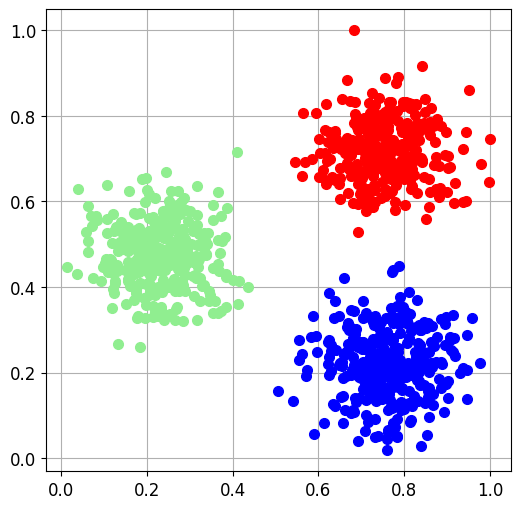

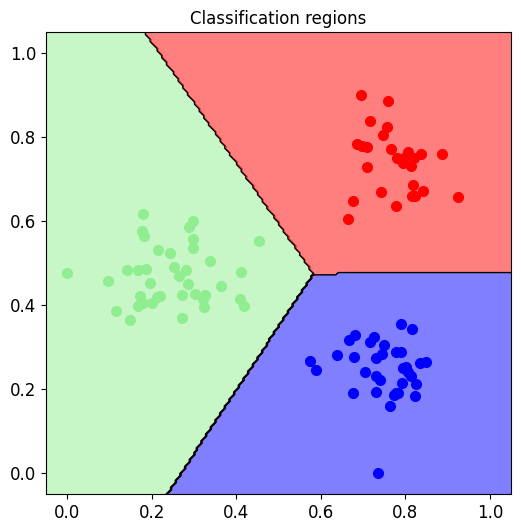

In [4]:
# wrapping a scikit-learn classifier
# This is WRONG!! we don't want to wrap a classifier but building a new one using secml
#from sklearn.svm import SVC
#from secml.ml.classifiers import CClassifierSkLearn
#model = SVC()
#secml_model = CClassifierSkLearn(model)

#FROM HERE is correct:

# SVM model using SecMl
from secml.ml.classifiers import CClassifierSVM
secml_model = CClassifierSVM()

# fit the model
secml_model.fit(tr.X, tr.Y)

# compute the accuracy
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()
accuracy = metric.performance_score(secml_model.predict(ts.X), ts.Y)

#accuracy = metric.performance_score(secml_model.predict(ts.X), ts.Y)
print("Accuracy on the test set", accuracy)
# later the plot

In [ ]:
# plot the learned decision function
%matplotlib inline

from secml.figure import CFigure

fig = CFigure()

# convenience function for plotting the decision function of a classifier
fig.sp.plot_decision_regions(secml_model, n_grid_points=200)

fig.sp.plot_ds(ts)
fig.sp.grid(grid_on=False)

fig.sp.title("Classification regions")
fig.show()

# Exercise 2 (10 Points)

Compute a security evaluation curve of the trained model using SecML, with the following setup:
* use the CFoolboxPGDLInf attack from the SecML library, with 20 iterations and 0.05 as absolute
* step size, no random start, lower bound 0 and upper bound 1
* use at least 8 values for the perturbation budget $\epsilon$. Which maximm value should you
* pick, starting from zero?
* plot the security evaluation curve using the ad-hoc method of the CFigure class

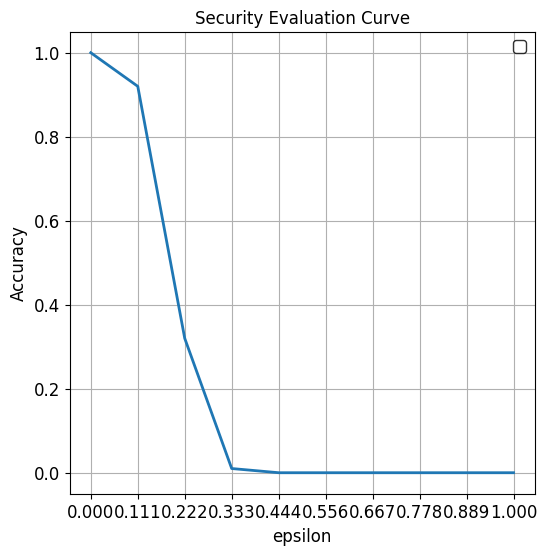

In [7]:
from secml.adv.attacks.evasion import CFoolboxPGDLinf
from secml.adv.seceval import CSecEval
import numpy as np


eps = np.linspace(0,1,10) # Here we set 1 as maximum value for the LINF attack, since it will cover all the input domain (normalized).
pgd_attack = CFoolboxPGDLinf(secml_model, None,
                           lb=0, ub=1,
                           epsilons=eps,
                           abs_stepsize=0.05,
                           steps=20, # iterations
                           random_start=False)


sec_eval = CSecEval(attack=pgd_attack, param_name='epsilon', param_values=eps)
sec_eval.run_sec_eval(ts)
# later the plot

In [ ]:
# plot
fig = CFigure()
fig.sp.plot_sec_eval(sec_eval.sec_eval_data)
# fig.show()

# Exercise 3 (2 Points)

Find and fix the bug of the proposed implementation of PGD L2, and execute it against the trained
classifer.

Original label 2
Adv label: 1


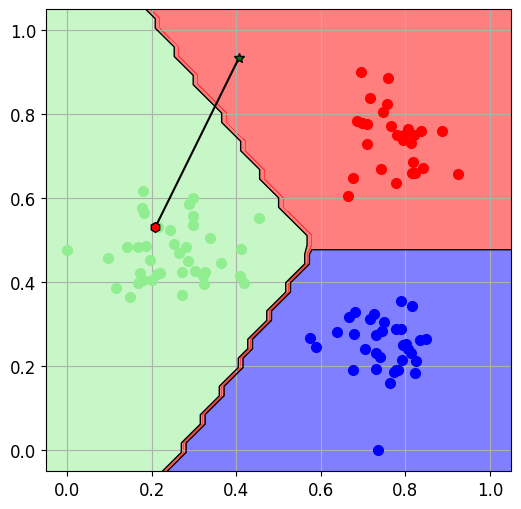

In [20]:
from secml.array import CArray
from secml.ml import CClassifier
from secml.ml.classifiers.loss import CLossCrossEntropy


def pgd_l2_targeted(clf : CClassifier, x : CArray, y_original : CArray, y_target : int, steps : int=20, eps: float=0.5, step_size : float=0.05, lb : int = 0, ub : int = 1):
  loss_func = CLossCrossEntropy()
  x_adv = x.deepcopy()
  path = CArray.zeros((steps, 2)) # add this for plotting
  for i in range(steps):
    scores = clf.decision_function(x_adv)
    #print(f'scores: {scores}')
    #targets = CArray.zeros((1, 3)) #
    #targets[scores.argmax()] = 1  #
    loss_gradient = loss_func.dloss(y_true=y_original, score=scores, pos_label=y_target)
    clf_gradient = clf.grad_f_x(x_adv, y_target)
    gradient = clf_gradient * loss_gradient

    if gradient.norm() != 0:
      gradient /= gradient.norm()

    x_adv = x_adv + step_size * gradient
    delta = x_adv - x
    if delta.norm() > eps:
      delta = delta / delta.norm()
      x_adv = x + delta * eps
    x_adv = x_adv.clip(lb, ub) # was missing
    path[i, :] = x_adv

  scores = clf.decision_function(x_adv)
  print(f'Adv label: {scores.argmax()}')
  return x_adv, path

sample, label = tr.X[0,:], tr.Y[0]
# later the plot


In [ ]:
# TODO call the function using the trained classifier at exercise 1
# NB: I added the code to plot
print("Original label", ts.Y[0].item())
x_adv, path = pgd_l2_targeted(secml_model, ts.X[0,:], ts.Y[0], 1, step_size=0.05) # call of the function

fig = CFigure()
fig.sp.plot_decision_regions(secml_model, n_grid_points=50)
fig.sp.plot_ds(ts)
fig.sp.plot_path(path)